# Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['text.usetex'] = True

def tangent(ra: float, dec: float) -> tuple[np.ndarray, np.ndarray]:
    """Returns the tangent vectors pointing to west and north.

    Args:
        ra (float): right ascension in degrees
        dec (float): declination in degrees

    Returns:
        tuple[float,float]: west and north vectors
    """
    # Convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    
    # Get sin and cos of ra and dec
    sinRa = np.sin(ra)
    cosRa = np.cos(ra)
    sinDec = np.sin(dec)
    cosDec = np.cos(dec)
    
    # Get tangent vectors
    west = np.array([sinRa, -cosRa, 0])
    north = np.array([-sinDec * cosRa, -sinDec * sinRa, cosDec])
    return west, north

## Load small data

In [2]:
data_path = 'data/match_4000710334517.csv'
data_df = pd.read_csv(data_path)

# Convert Image IDs to integers in range [0, number of images]
data_df.ImageID = pd.factorize(data_df.ImageID)[0]

# Get kappas (inverse of sigma)
data_df["kappa"] = 1 / (data_df["sigma"] ** 2)
data_df["kappa (radians)"] = 1 / ((data_df["sigma"]*np.pi/180/3600) ** 2)
data_df["log kappa (radians)"] = np.log(data_df["kappa (radians)"])

data_df.head()

,MatchID,SubID,RA,Dec,ImageID,SourceID,X,Y,Z,sigma,kappa,kappa (radians),log kappa (radians)
0,4000710334517,0,269.749758,-29.186608,0,4001061039486,-0.003813,-0.873028,-0.487656,0.03655,748.557635,3.184751e+13,31.091980
1,4000710334517,0,269.749758,-29.186608,1,4001212780699,-0.003814,-0.873028,-0.487656,0.06405,243.759586,1.037079e+13,29.970015
2,4000710334517,0,269.749758,-29.186608,1,4001212780710,-0.003812,-0.873028,-0.487656,0.03850,674.650059,2.870310e+13,30.988026
3,4000710334517,0,269.749758,-29.186608,2,4001120525362,-0.003813,-0.873028,-0.487656,0.03395,867.601807,3.691227e+13,31.239565
4,4000710334517,0,269.749758,-29.186608,3,4001152086466,-0.003813,-0.873028,-0.487656,0.01605,3881.949811,1.651582e+14,32.737925


## Convert to 2D coordinates
Do dot product with tangent vectors (north and west) to get x and y (in radians) Blur is the same because it's the same instrument. 

In [3]:
from collections import defaultdict

counts = defaultdict(int)
for row in data_df.itertuples():
    counts[(row.RA, row.Dec)] += 1

# Calculate center of all objects in Ra and Dec
centers_ra_decs = list(counts.keys())
num_counts = sum(counts.values())
center_ra = sum(c[0] * counts[c] for c in centers_ra_decs) / num_counts
center_dec = sum(c[1] * counts[c] for c in centers_ra_decs) / num_counts

In [4]:
# Convert to west/north coordinates
center_west, center_north = tangent(center_ra, center_dec)

data_df["coord1 (arcseconds)"] = (data_df[["X", "Y", "Z"]] @ center_west) * 180 * 3600 / np.pi
data_df["coord2 (arcseconds)"] = (data_df[["X", "Y", "Z"]] @ center_north) * 180 * 3600 / np.pi

## Cluster

In [2]:
from scipy import spatial

def neg_log_bayes(data_df: pd.DataFrame, labels: list[int]) -> float:
    """ Calculate negative log bayes factor using the given labels.

    Args:
        data_df (pd.DataFrame): Data dataframe with coordinates and uncertainties
        labels (list[int]): integer array of labels

    Returns:
        float: negative log bayes factor
    """
    out = 0
    data_df["labels"] = labels

    for i in range(max(labels)):
        # filter data to sources labeled to i
        data_labeled = data_df[data_df.labels == i]

        # get 2D coordinates of sources
        # coords = data_labeled[["coord1 (arcseconds)", "coord2 (arcseconds)"]]
        coord1 = data_labeled["coord1 (arcseconds)"]
        coord2 = data_labeled["coord2 (arcseconds)"]
        weights = data_labeled["kappa"]

        # Get centroid
        centroid1 = (coord1 * weights).sum() / weights.sum()
        centroid2 = (coord2 * weights).sum() / weights.sum()

        # Get number of sources
        num_sources = data_labeled.shape[0]

        # Get kappa sums
        sum_ln_kappa_rad = data_labeled["log kappa (radians)"].sum()
        ln_sum_kappa_rad = np.log(data_labeled["kappa (radians)"].sum())
        sum_kappa = data_labeled["kappa"].sum()

        # Get sum of pairwise distances between all sources
        sum_of_square_dist = np.power(coord1 - centroid1, 2) + np.power(coord2 - centroid2, 2)

        # Divide by 4 * sum of kappas
        double_sum = sum_of_square_dist / 4

        # Add up all terms
        out += (1 - num_sources) * np.log(2) - sum_ln_kappa_rad + ln_sum_kappa_rad + double_sum

    # Remove the label column
    del data_df["labels"]

    return out

In [31]:
for i in range(max(data_df.ImageID)):
    data_img = data_df[data_df.ImageID == i]
    counts = data_img.SourceID.value_counts()

    for c in counts:
        if c > 1:
            print(f"Image {i} has two sources clustered together")

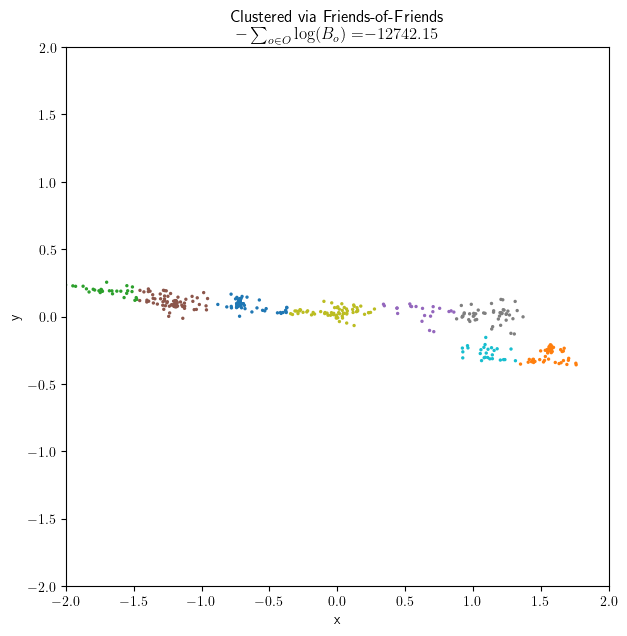

In [7]:
plt.figure(figsize=(7,7))
plt.scatter(data_df['coord1 (arcseconds)'],
            data_df['coord2 (arcseconds)'],
            s=2.0, c = data_df.SubID, cmap='tab10')
plt.title("Clustered via Friends-of-Friends\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df, list(data_df.SubID)):.2f}$")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

### KMeans

100%|██████████| 49/49 [00:04<00:00, 11.66it/s]


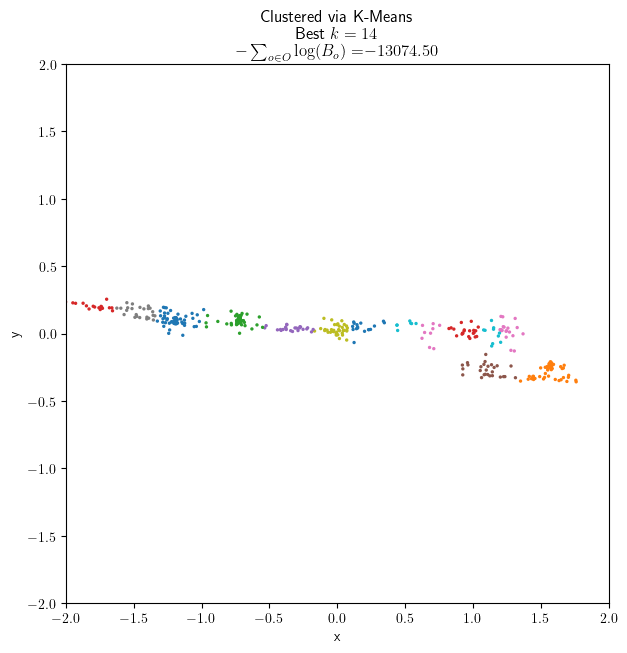

In [26]:
from sklearn.cluster import KMeans
from tqdm import tqdm
from collections import defaultdict

coords = data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]]
weights = data_df["kappa"]

best_labels = None
best_k = 0
best_bayes = np.Inf

for k in tqdm(range(1,50)):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X = coords, sample_weight=weights)

    bayes = neg_log_bayes(data_df, kmeans.labels_)

    if bayes < best_bayes:
        best_bayes = bayes
        best_labels = kmeans.labels_
        best_k = k

plt.figure(figsize=(7,7))
plt.scatter(data_df['coord1 (arcseconds)'],
            data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab10')
plt.title("Clustered via K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

In [ ]:
for i in range(max(kmeans.labels_)):
    data_img = data_df[data_df.ImageID == i]
    counts = data_img.SourceID.value_counts()

    for c in counts:
        if c > 1:
            print(f"Image {i} has two sources clustered together")

### COP-KMeans

100%|██████████| 49/49 [00:16<00:00,  2.99it/s]


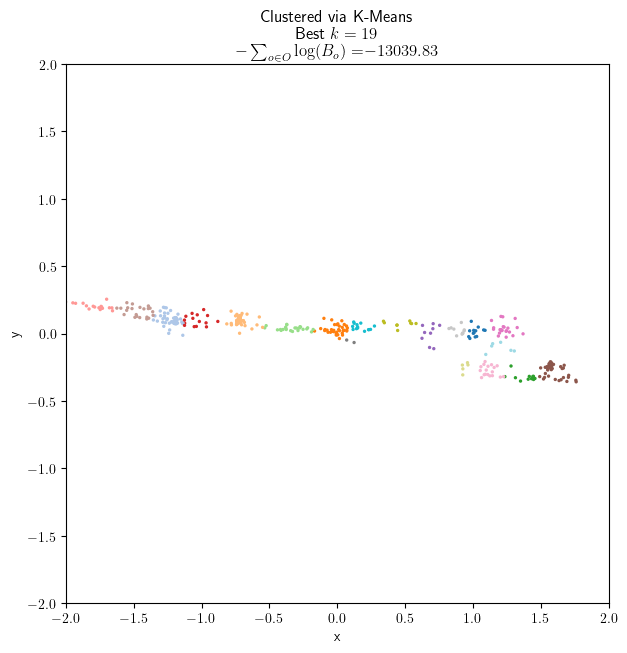

In [34]:
from cop_kmeans import cop_kmeans
import itertools

coords = data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]].to_numpy()
weights = data_df["kappa"]

# Create cannot-links (list of tuples)
cannot_link_dict: dict[int,list[int]] = dict()

for i in range(max(data_df.ImageID)):
    cannot_link_dict[i] = data_df[data_df.ImageID == i].index.to_list()

cannot_link = []

for l in cannot_link_dict.values():
    for comb in itertools.combinations(l,2):
        cannot_link.append(comb)

best_labels = None
best_k = 0
best_bayes = np.Inf

for k in tqdm(range(1,50)):
    clusters, centers = cop_kmeans(dataset=coords, initialization="kmpp", k=k, ml=[],cl=cannot_link, sample_weights=weights)
    
    if clusters is None:
        continue

    bayes = neg_log_bayes(data_df, clusters)

    if bayes < best_bayes:
        best_bayes = bayes
        best_labels = clusters
        best_k = k

plt.figure(figsize=(7,7))
plt.scatter(data_df['coord1 (arcseconds)'],
            data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab20')
plt.title("Clustered via K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

## Big Data

In [3]:
big_data_path = "big_data/MyHDF_jacobf18_0.csv"
big_data_df = pd.read_csv(big_data_path)

# Convert Image IDs to integers in range [0, number of images]
big_data_df.ImageID = pd.factorize(big_data_df.ImageID)[0]

# Get kappas (inverse of sigma)
big_data_df["kappa"] = 1 / (big_data_df.Sigma ** 2)
big_data_df["kappa (radians)"] = 1 / ((big_data_df.Sigma*np.pi/180/3600) ** 2)
big_data_df["log kappa (radians)"] = np.log(big_data_df["kappa (radians)"])

big_data_df.head()

,ImageID,JobID,MatchID,SourceID,X,Y,Z,Sigma,RA,Dec,kappa,kappa (radians),log kappa (radians)
0,0,35306,4211611957,4000916189528,0.456528,-0.182370,-0.870817,0.02900,338.225364,-60.552930,1189.060564,5.058878e+13,31.554751
1,0,35306,4211611904,4000916189529,0.456427,-0.182594,-0.870823,0.01000,338.196765,-60.553629,10000.000000,4.254517e+14,33.684173
2,0,35306,4211611842,4000916189530,0.456499,-0.182411,-0.870824,0.01875,338.219733,-60.553715,2844.444444,1.210174e+14,32.426955
3,0,35306,4211611919,4000916189532,0.456505,-0.182411,-0.870821,0.01110,338.219887,-60.553379,8116.224123,3.453061e+14,33.475452
4,0,35306,4211612082,4000916189535,0.456455,-0.182547,-0.870819,0.02810,338.203047,-60.553056,1266.448045,5.388125e+13,31.617804


### Convert to 2D Coordinates

In [4]:
# Get center of data points
center_ra = big_data_df.RA.mean()
center_dec = big_data_df.Dec.mean()

center_west, center_north = tangent(center_ra, center_dec)

big_data_df["coord1 (arcseconds)"] = (big_data_df[["X", "Y", "Z"]] @ center_west) * 180 * 3600 / np.pi
big_data_df["coord2 (arcseconds)"] = (big_data_df[["X", "Y", "Z"]] @ center_north) * 180 * 3600 / np.pi

big_data_df

,ImageID,JobID,MatchID,SourceID,X,Y,Z,Sigma,RA,Dec,kappa,kappa (radians),log kappa (radians),coord1 (arcseconds),coord2 (arcseconds)
0,0,35306,4211611957,4000916189528,0.456528,-0.182370,-0.870817,0.02900,338.225364,-60.552930,1189.060564,5.058878e+13,31.554751,10.930064,-5.757109
1,0,35306,4211611904,4000916189529,0.456427,-0.182594,-0.870823,0.01000,338.196765,-60.553629,10000.000000,4.254517e+14,33.684173,61.544402,-8.301104
2,0,35306,4211611842,4000916189530,0.456499,-0.182411,-0.870824,0.01875,338.219733,-60.553715,2844.444444,1.210174e+14,32.426955,20.895535,-8.587093
3,0,35306,4211611919,4000916189532,0.456505,-0.182411,-0.870821,0.01110,338.219887,-60.553379,8116.224123,3.453061e+14,33.475452,20.623653,-7.377742
4,0,35306,4211612082,4000916189535,0.456455,-0.182547,-0.870819,0.02810,338.203047,-60.553056,1266.448045,5.388125e+13,31.617804,50.428467,-6.230797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60500,55,35306,4600995538,4600995538,0.456473,-0.182048,-0.870914,0.10680,338.256965,-60.564915,87.671305,3.729991e+12,28.947427,-46.624523,-46.174268
60501,55,35306,4600995523,4600995523,0.456340,-0.182410,-0.870908,0.02490,338.211995,-60.564248,1612.877199,6.862014e+13,31.859607,32.937911,-43.786583
60502,55,35306,4600995488,4600995488,0.456445,-0.182132,-0.870911,0.07570,338.246640,-60.564574,174.505139,7.424351e+12,29.635786,-28.356915,-44.944932
60503,55,35306,4600995480,4600995480,0.456368,-0.182323,-0.870911,0.14380,338.222590,-60.564618,48.359547,2.057465e+12,28.352496,14.191576,-45.110163


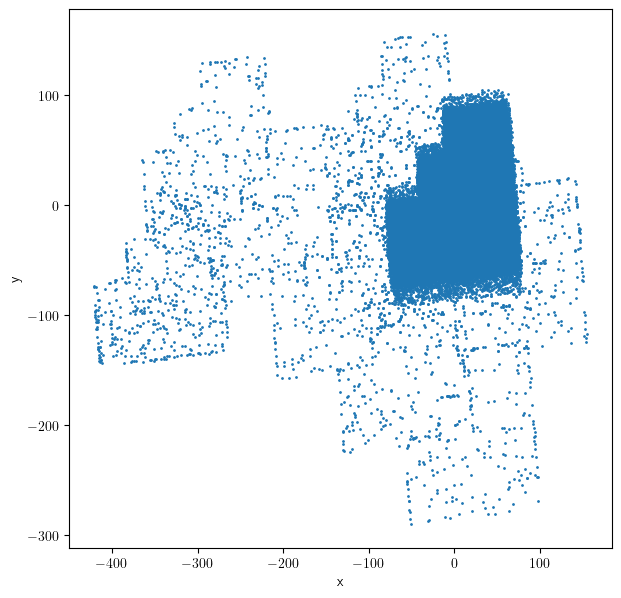

In [5]:
plt.figure(figsize=(7,7))
plt.scatter(big_data_df['coord1 (arcseconds)'],
            big_data_df['coord2 (arcseconds)'],
            s=1.0)
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

In [12]:
from sklearn.cluster import KMeans
from tqdm import tqdm
from collections import defaultdict

coords = big_data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]]
weights = big_data_df["kappa"]

In [13]:
best_labels = None
best_k = 0
best_bayes = np.Inf

for k in tqdm(range(1,50)):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X = coords, sample_weight=weights)

    # bayes = neg_log_bayes(big_data_df, kmeans.labels_)

    # if bayes < best_bayes:
    #     best_bayes = bayes
    #     best_labels = kmeans.labels_
    #     best_k = k

# plt.figure(figsize=(7,7))
# plt.scatter(big_data_df['coord1 (arcseconds)'],
#             big_data_df['coord2 (arcseconds)'],
#             s=2.0, c = best_labels, cmap='tab20')
# plt.title("Clustered via K-Means\n"
#           f"Best $k={best_k}$\n"
#               r"$-\sum_{{o\in O}}\log(B_o)=$"
#               f"${best_bayes:.2f}$")
# plt.xlabel('x')
# plt.ylabel('y')
# # plt.xlim([-2,2])
# # plt.ylim([-2,2])
# plt.show()

 98%|█████████▊| 48/49 [01:15<00:02,  2.61s/it]

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 
100%|██████████| 49/49 [01:17<00:00,  1.59s/it]
